### 복습(GAN)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

In [7]:
## generator
generator = Sequential(name = 'generator')
generator.add(Dense(128*7*7, input_shape = (100, )))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_5 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        20

In [15]:
## discriminator
discriminator = Sequential(name = 'discriminator')
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = 'same')) # input_shape 마지막 1 흑백 뜻
discriminator.add(Activation(LeakyReLU(0.2))) # 0보다 적을때 기울기 0.2, 클때는 1
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2))) # 0보다 적을때 기울기 0.2, 클때는 1
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer='adam')
discriminator.trainable = False # discriminator 로 학습하지 않는다는 뜻

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_9 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_10 (Activation)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)            

In [16]:
## generator 와 discriminator 연결
ginput = Input(shape = (100, ))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         865281    
                                                                 
 discriminator (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [25]:
## train 함수 설정
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train.reshape(-1, 28, 28, 1)
    X_train = (X_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 0))

    for i in range(epoch):

        ## 실제에 대한 loss
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        ## 가짜에 대한 loss
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            gen_imgs = 0.5 * gen_imgs + 0.5
            # gen_imgs = (gen_imgs + 0.5) / 0.5

            fig, ax = plt.subplots(5, 5)

            count = 0
            for i in range(5):
                for j in range(5):
                    ax[i, j].imshow(gen_imgs[count], cmap = 'gray')
                    ax[i, j].axis('off')
                    count += 1
            fig.savefig('./gan_image_{}'.format(i))


1/1 [==============================] - 0s 40ms/step


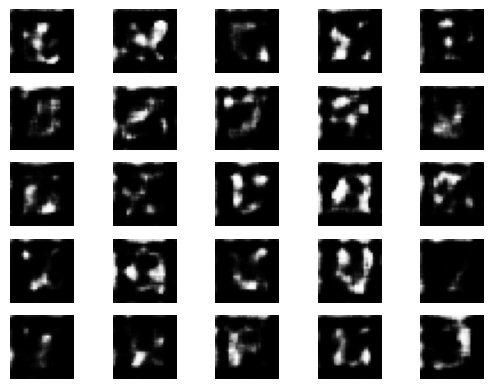

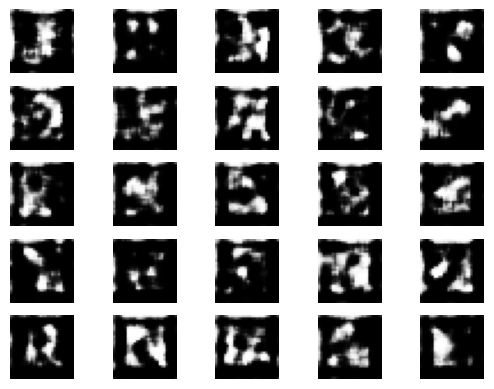

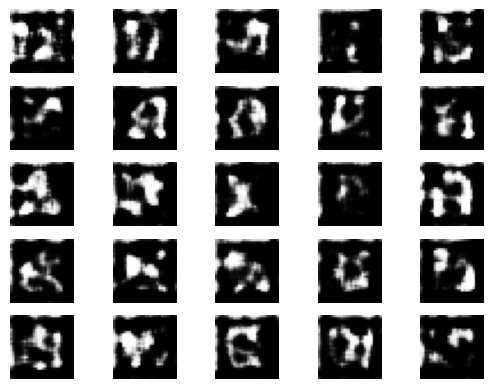

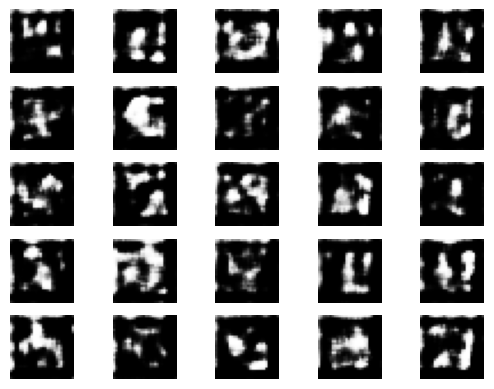

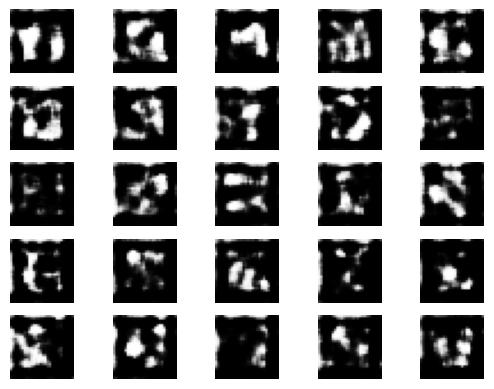

In [26]:
gan_train(1000, 32, 200)

### 전이학습

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D

#### 치매환자의 뇌인지 일반인의 뇌인지 예측

In [43]:
train_datagen = ImageDataGenerator(rescale= 1/255., horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, shear_range=0.7, zoom_range=[0.9, 2.2], vertical_flip=True, fill_mode='nearest')

In [44]:
train_generator = train_datagen.flow_from_directory(directory='./data/train/', target_size=(150, 150), color_mode='rgb', save_to_dir='./data/gen_train/', batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.


In [45]:
test_datagen = ImageDataGenerator(rescale=1/255.)

In [46]:
test_generator = test_datagen.flow_from_directory(directory='./data/test/', target_size=(150, 150), save_to_dir=('./data/gen_test/'), batch_size=5, class_mode='binary')

Found 120 images belonging to 2 classes.


#### CNN 모델 생성

In [47]:
del model

In [48]:
model = Sequential(name = 'AD')
model.add(Conv2D(32, kernel_size = 3, input_shape = (150, 150, 3))) # 흑백인데 3으로 들어옴
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size = 3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5)) # flatten 이후 dropout 쓰는게 일반적임
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "AD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 82944)             0        

In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')
earlystop = tf.keras.callbacks.EarlyStopping(patience=5)

In [50]:
history = model.fit(x = train_generator, epochs=100, steps_per_epoch=32, batch_size=50, validation_data=test_generator, validation_steps=24, callbacks=[earlystop])

Epoch 1/100
32/32 [==============================] - 6s 181ms/step - loss: 0.8107 - acc: 0.5000 - val_loss: 0.7543 - val_acc: 0.5000
Epoch 2/100
32/32 [==============================] - 6s 177ms/step - loss: 0.7208 - acc: 0.5500 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 3/100
32/32 [==============================] - 4s 123ms/step - loss: 0.6743 - acc: 0.5500 - val_loss: 0.6487 - val_acc: 0.7583
Epoch 4/100
32/32 [==============================] - 4s 123ms/step - loss: 0.6833 - acc: 0.5437 - val_loss: 0.6983 - val_acc: 0.5000
Epoch 5/100
32/32 [==============================] - 4s 120ms/step - loss: 0.6718 - acc: 0.5938 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 6/100
32/32 [==============================] - 4s 123ms/step - loss: 0.6629 - acc: 0.5875 - val_loss: 0.9303 - val_acc: 0.5000
Epoch 7/100
32/32 [==============================] - 4s 120ms/step - loss: 0.6865 - acc: 0.5938 - val_loss: 0.6046 - val_acc: 0.7833
Epoch 8/100
32/32 [==============================] - 4s 121ms/step - 

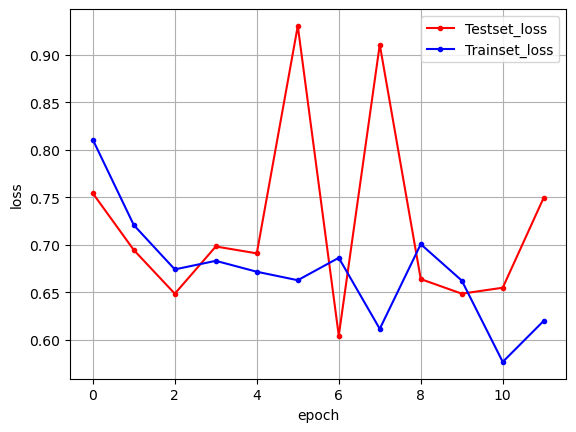

In [51]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### transfer 학습

In [53]:
from tensorflow.keras.applications import VGG16

In [54]:
train_datagen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

In [56]:
train_generator = train_datagen.flow_from_directory('./data/train/', target_size=(150,150), batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.


In [57]:
test_datagen = ImageDataGenerator(rescale=1/255.)

In [58]:
test_generator = test_datagen.flow_from_directory('./data/test/', target_size=(150,150), batch_size=5, class_mode='binary')

Found 120 images belonging to 2 classes.


In [60]:
## VGG 모델 가져오기
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
transfer_model.trainable = False # False로 해야 weight 등이 변하지 않음
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [61]:
# finetune (기존 모델 가져와서 우리꺼에 맞게끔 수정)
finetune_model = Sequential(name='finetune')
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.3))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Model: "finetune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                524352    
                                                                 
 activation_17 (Activation)  (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
 activation_18 (Activation)  (None, 1)                 0  

In [63]:
finetune_model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002), metrics='acc')

In [64]:
history = finetune_model.fit(train_generator, epochs=20, validation_data=test_generator, validation_steps=10, callbacks=[earlystop])

Epoch 1/20
32/32 [==============================] - 9s 246ms/step - loss: 0.6538 - acc: 0.6375 - val_loss: 0.5994 - val_acc: 0.6000
Epoch 2/20
32/32 [==============================] - 8s 247ms/step - loss: 0.4854 - acc: 0.7688 - val_loss: 0.3677 - val_acc: 0.9400
Epoch 3/20
32/32 [==============================] - 8s 266ms/step - loss: 0.3729 - acc: 0.8687 - val_loss: 0.3415 - val_acc: 0.8400
Epoch 4/20
32/32 [==============================] - 8s 248ms/step - loss: 0.3348 - acc: 0.9000 - val_loss: 0.2563 - val_acc: 0.9400
Epoch 5/20
32/32 [==============================] - 7s 233ms/step - loss: 0.2777 - acc: 0.9187 - val_loss: 0.3013 - val_acc: 0.9000
Epoch 6/20
32/32 [==============================] - 8s 254ms/step - loss: 0.2564 - acc: 0.9312 - val_loss: 0.2248 - val_acc: 0.9400
Epoch 7/20
32/32 [==============================] - 7s 232ms/step - loss: 0.2225 - acc: 0.9500 - val_loss: 0.1664 - val_acc: 0.9800
Epoch 8/20
32/32 [==============================] - 7s 233ms/step - loss: 0.

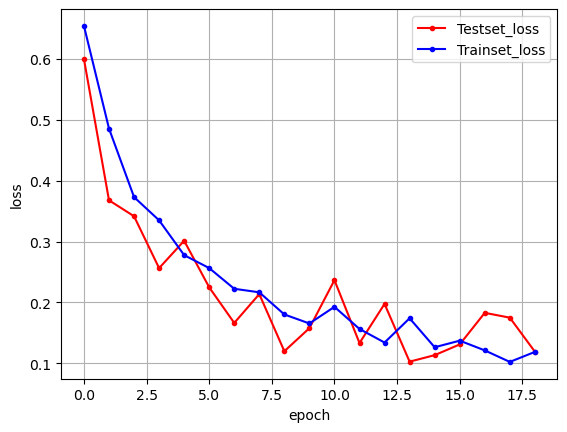

In [68]:
# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, history.history['val_loss'], marker='.', c="red", label='Testset_loss')
plt.plot(x_len, history.history['loss'], marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 설명 가능한 딥러닝 모델

In [72]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.image as mpimg

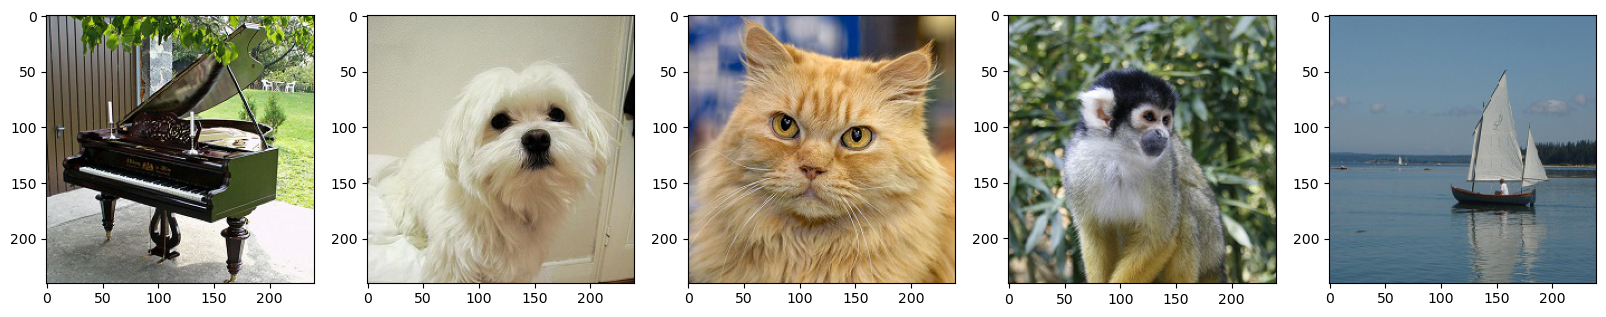

In [77]:
images_originals = []

for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

fig, ax = plt.subplots(1,5, figsize=(20,5))

for i, image_o in enumerate(images_originals):
    ax[i].imshow(image_o)
plt.show()

In [78]:
model = VGG16(weights='imagenet', include_top=True)

input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

553467096/553467096 [==============================] - 404s 1us/step


#### 그레이디언트 CAM 알고리즘

In [85]:
explainer = GradCAM()

In [88]:
for l, i in zip(input_list, imagenet_index):  
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224,224)) 
    img = img_to_array(img) # 이미지를 넘파이 배열로
    data = ([img], None)
    grid = explainer.explain(data, model, int(i))  
    explainer.save(grid, ".", './data/img/{}_cam.jpg'.format(l)) 

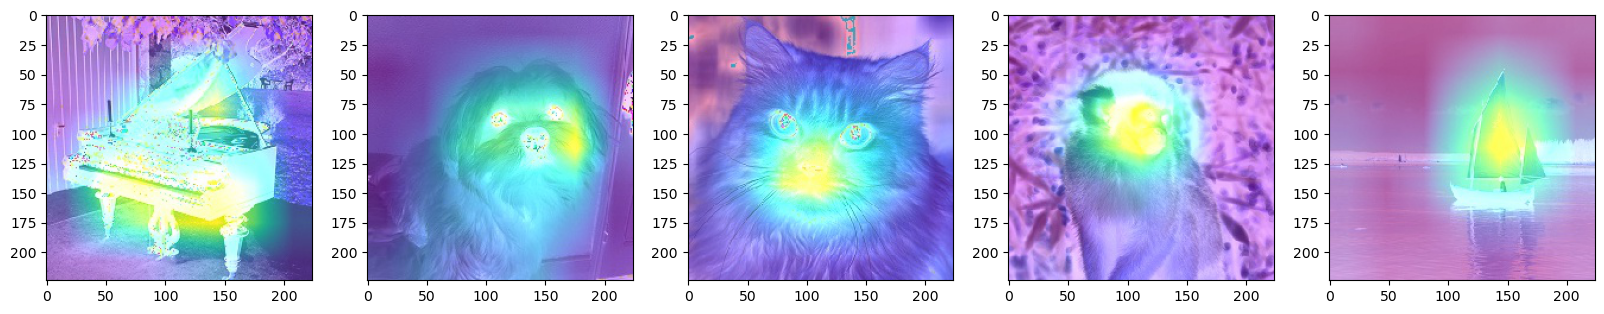

In [95]:
images_cams = []
for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))
plt.figure(figsize=(20,20))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i+1)
    plt.imshow(image_c)


#### 오클루전 알고리즘

In [90]:
explainer = OcclusionSensitivity()
images_occ1 = []
patch_size = 40
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224,224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size)  # 패치 크기 설정이 추가
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

2/2 [==============================] - 3s 433ms/step


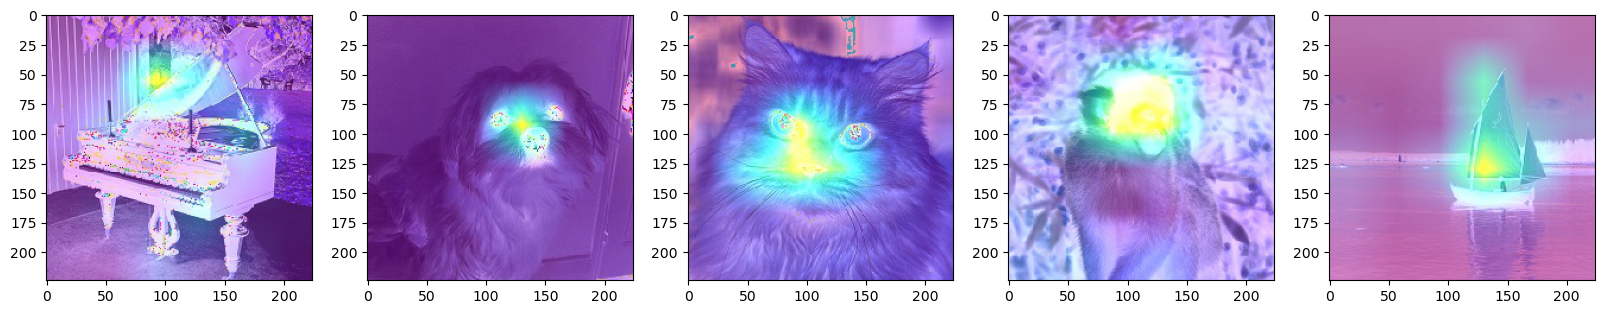

In [91]:
# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1):
    plt.subplot(5, 5, i+1)
    plt.imshow(image)